# Introduction



Click-through rate (CTR) prediction is a critical task in online display advertising. In this project we implement several calassification models, evaluate their results and compare their strength and weeknesses.
We use the Sharif DataDays 2020 dataset.

We first clean and balance the data, then train the models on the training-set, tune their hyperparameters on the validation-set, and evaluate them with the test-set.
the models we have considered are Logistic Regression, SVM, Random Forest, XGBosst, Factoriztion Machine (FM), and Field Weighted Factorization Machine (FwFM).

# Data Prepration

The dataset is a multi-field categorical data. Each row in dataset consists of 15 fields with a target-value labled as either "Clicked" or "Not Clicked".


|# | Fields     | Description                          |
|--|------------|--------------------------------------|
|1| displayId | Unique id for the displaying ad to the user |
|2| timspamp | Timestamp of when click happens |
|3| dayOfWeek | Day of week related to the timestamp |
|4| hourOfDay | hour of day related to the timestampm |
|5| publisher | Unique id for the publisher site which shows the ad  |
|6| source | Unique id for the section of publisher site which the ad was in  |
|7| docId | Unique id for the page which contains the ad |
|8| widgetId | Unique id for the placement of ad in page  |
|9| userId | Unique id for the user |
|10| device | unique id for device of user. i.e., PC, Cellphone |
|11| os     | operation system of user. i.e., Ubunutu|
|12| browser  | browser of user. i.e., Chrome|
|13| adveertiserId  | Unique id for advertiser |
|14| compaignId  | Unique id for the compaign of the ad |
|15| creativeId | Unique id for the ad |
|16| clicked | status of clicking or not clicking of thee user on the ad|

The dataset is collected in the following manner:

In each view, multiple ads (with a same *`displayId`*) are shown to a user simultaneously. The user will choose one and only one of these ads. So the problem is about selecting the most related one from a group of suggested ads.

With this in mind, we split the dataset into training-set, validationn-set, and tset-set with this contition that each group of ads with the same *`displayId`* belong to the same subset of data.

We do this because the problem is not just about predicting clicked based on the features, but it is about selecting the most probable one in a group of ads with the same *`displayId`*.

### Download/Extract Datasets

In [75]:
!wget https://www.dropbox.com/s/gesb5v1q0cwtrmn/MLFinalProjectDataset.zip

--2021-02-09 15:48:31--  https://www.dropbox.com/s/gesb5v1q0cwtrmn/MLFinalProjectDataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/gesb5v1q0cwtrmn/MLFinalProjectDataset.zip [following]
--2021-02-09 15:48:32--  https://www.dropbox.com/s/raw/gesb5v1q0cwtrmn/MLFinalProjectDataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0e66bdecb29a254d01e8e60ade.dl.dropboxusercontent.com/cd/0/inline/BIkouslHxXypoi4jFaDXL3RLnExa5Oa7hOhzB0lZ8wBD0ifRgmcwkyUmooOgpWa7EM9faTeDmAcid-C7QifLPrbL0mGmmtHITcHrMUbof1vyqXWMPOIAauYhvkBx34zHXps/file# [following]
--2021-02-09 15:48:32--  https://uc0e66bdecb29a254d01e8e60ade.dl.dropboxusercontent.com/cd/0/inline/BIkouslHxXypoi4jFaDXL3RLnExa5Oa7hOhzB0lZ8wBD0ifRgmcwkyUmooOgpWa7EM9faTeD

In [76]:
!unzip MLFinalProjectDataset.zip -d dataset

Archive:  MLFinalProjectDataset.zip
replace dataset/train_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/train_data.csv  
  inflating: dataset/__MACOSX/._train_data.csv  
  inflating: dataset/test_data.csv   


In [156]:
!pip install category_encoders

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn import model_selection
from sklearn import svm
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import decomposition
from category_encoders import TargetEncoder
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, log_loss
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE

!pip install watermark
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, log_loss, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from numba import njit
from tqdm import trange
from sklearn.base import BaseEstimator, ClassifierMixin

%watermark -a 'Ethen' -d -t -v -p numba,numpy,pandas,sklearn,matplotlib

np.random.seed(12345)

Ethen 2021-02-09 17:48:34 

CPython 3.6.9
IPython 5.5.0

numba 0.51.2
numpy 1.19.5
pandas 1.1.5
sklearn 0.0
matplotlib 3.2.2


## Load Datasets


In [78]:
very_test_data = pd.read_csv("dataset/test_data.csv")
very_test_data.head(3)

,displayId,timestamp,dayOfWeek,hourOfDay,advertiserId,campaignId,creativeId,publisher,widgetId,device,os,browser,source,docId,userId
0,1204095,1579638603061,4,0,6620,5773,7208,131,7006,0,0,0,139,1330976,697233
1,1204095,1579638603061,4,0,5180,6099,7003,131,7006,0,0,0,139,1330976,697233
2,1204095,1579638603061,4,0,5971,251,7125,131,7006,0,0,0,139,1330976,697233


In [79]:
data = pd.read_csv("dataset/train_data.csv")
data.head()

,displayId,timestamp,dayOfWeek,hourOfDay,advertiserId,campaignId,creativeId,publisher,widgetId,device,os,browser,source,docId,userId,clicked
0,4706262,1578429005696,4,0,290,7855,6,10,6262,0,0,0,11,3543873,2688642,1
1,4706262,1578429005696,4,0,1386,7967,15,10,6262,0,0,0,11,3543873,2688642,0
2,4706262,1578429005696,4,0,378,1160,3610,10,6262,0,0,0,11,3543873,2688642,0
3,4706267,1578429007726,4,0,6642,804,3475,14,607,1,3,0,15,6245475,2688641,1
4,4706267,1578429007726,4,0,8414,6155,5271,14,607,1,3,0,15,6245475,2688641,0


## Split Dataset

We split the dataset into training-set, validation-set, and test-set randomly by 60%:20%:20%.

These percentages are for *`displayId`*s. i.e., the training-set consists of 60% unique *`displayId`*s which is also 60% *`clicked`*s, It is also 60% of all rows either.


`get_target_percentage` function returns target value distribution along the given dataset.

In [80]:
def get_target_percentage(data):
  class0 = (data["clicked"] == 0).sum()
  class1 = (data["clicked"] == 1).sum() 
  return class0 + class1, class0, class1, class1 / (class0 + class1)

In [81]:
get_target_percentage(data)

(3768416, 2926235, 842181, 0.22348408455966645)

In [82]:
display_ids = data.displayId.value_counts()
train_sample = display_ids.sample(frac=0.6)
train_data = data[data.displayId.isin(train_sample.index)]
other_data = data[~data.displayId.isin(train_sample.index)]

In [83]:
display_ids = other_data.displayId.value_counts()
test_sample = display_ids.sample(frac=0.5)
test_data = other_data[other_data.displayId.isin(test_sample.index)]
validation_data = other_data[~other_data.displayId.isin(test_sample.index)]

In [84]:
train_data.shape, validation_data.shape, test_data.shape

((2261907, 16), (753252, 16), (753257, 16))

# Field Selection and Eliminating Outliers

In this section we aim to detect fields with high corrolation with clicked. Fields with high corrolation with each other are considered as redundant so we choose one of them to reduce bias and improve efficency.

After selecting the desierable fields, We need to delete outliers data. We filter out all data appeares less than a specefic times in the training-set. i.e., a publisher with a few user inntraction cant improve our models. Another approach to deal with these non-informative data is replacing them with NULL.

## Utils

`get_corrolation_with_column` function returns the corrolation of data to the given column name in the decreasing order

`corrolation_heatmap` function plots corrolationn heatmap of the given dataframe columns 

`transform_to_target_encoder` function encode the given dataframe categorical data with TargetEncoding  

In [85]:
def get_corrolation_with_column(data, column):
  return data.corr()[column].sort_values(ascending=False, key=lambda x: abs(x))

def corrolation_heatmap(data):
  size = len(data.columns)
  plt.figure(figsize=(size, size))
  return sns.heatmap(
    data.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
  )

def tranform_to_target_encoded(data, columns=None):
  if columns is None:
    columns = data.columns
  encoder = TargetEncoder(cols=columns)
  data_encoded = pd.DataFrame()
  data_encoded= encoder.fit_transform(data, data['clicked'])
  return data_encoded

## EDA

For the first step of detect corrolated fields, We find the corrolation of data fields with *`clicked`*. The result does not give any insight for feature selection.

In [86]:
get_corrolation_with_column(train_data, "clicked")

clicked         1.000000
device         -0.060342
os             -0.046867
creativeId     -0.027686
hourOfDay       0.025198
publisher       0.020127
advertiserId   -0.018648
source          0.015727
browser        -0.014138
widgetId       -0.012071
displayId      -0.011087
timestamp       0.010772
campaignId     -0.006895
userId         -0.006553
docId          -0.005822
dayOfWeek       0.005524
Name: clicked, dtype: float64

Next, We plot corrolation heatmap of train-set fields. As we mentioned before, we have to drop high corrolated fields because of performance and bias.

As we can see, the *`displayId`* and the *`timestamp`* are completely corrolated, we expect this corrolation becase the *`displayId`* is uniqe per ads view and *`timestamp`* is also unique (because of low probablity of happening at the same tiem).

The *`os`*, the *`device`*, and the *`browser`* is also corrolated because specefic device supports specefic os and browsers are also different per operation system.

Another significant corrolation is the corrolation between *`publisher`* and *`source`* which means each publisher serves ads on defined part of their platforms.

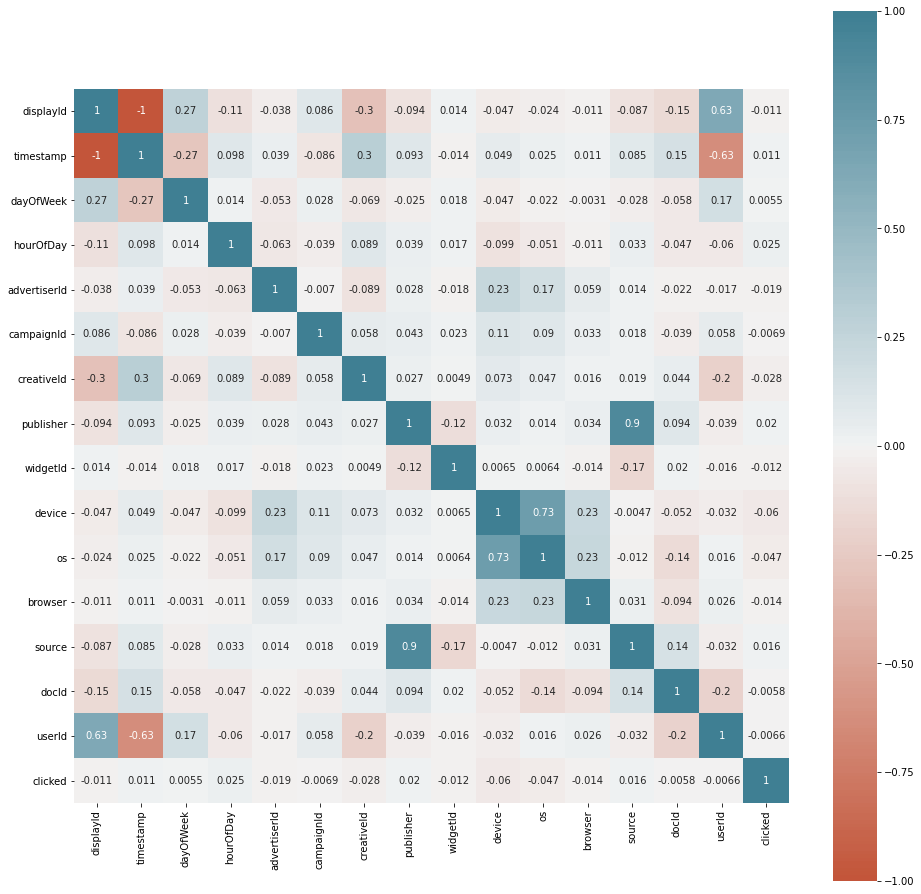

In [87]:
corrolation_heatmap(train_data);

From the previouse part and detected corrolation, we can group fields to 4 related groups, *Advertiser*, *Publisher*, *User*, *Other*. beside, coceptualy each row of data describe and ad-view. each ad-view has an advertiser which provides the ad, a publisher which shows the ad to the user and a user who see the ad, other fields also related to the time that event happens.

| Group      | Fields                               |
|------------|--------------------------------------|
| Advertiser | AdvertiserId, CampaignId, CreativeId |
| Publisher  | publisher, source, docId, widgetId   |
| User       | userId, device, os, browser            |
| Other      | desplayId, timestamp, dayOfWeek, hourOfDay|

Now for each group we see corrolations between fields closely.

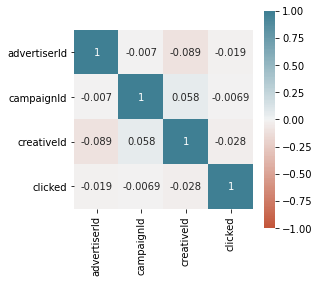

In [88]:
corrolation_heatmap(train_data[["advertiserId", "campaignId", "creativeId", "clicked"]]);

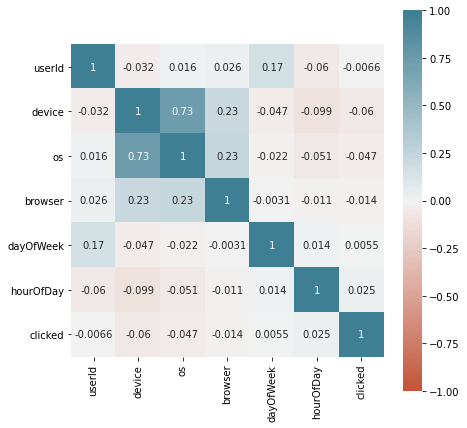

In [89]:
corrolation_heatmap(train_data[["userId", "device", "os", "browser", "dayOfWeek", "hourOfDay", "clicked"]]);

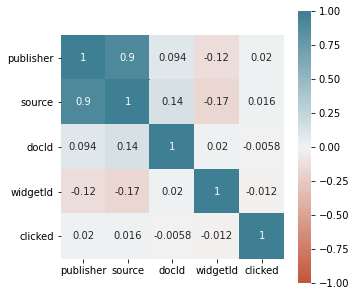

In [90]:
corrolation_heatmap(train_data[["publisher", "source", "docId", "widgetId", "clicked"]]);

Because most of the dataset fields are categorical, we use a categorical encoding to transform the data. The TargetEncoder does a probabilistical analysis on the dataset and replace each entry with blend of the expected value of the target given particular field value and the expected value of the target over all the training-set.

Corrolation between columns of transformed data shows corrolation between members of each group.

The only exception in userId whick is in publisher group. sites a user see shows their interests. On the other hand, each user has many devices and can not shows interests as much as sites can shows. 

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


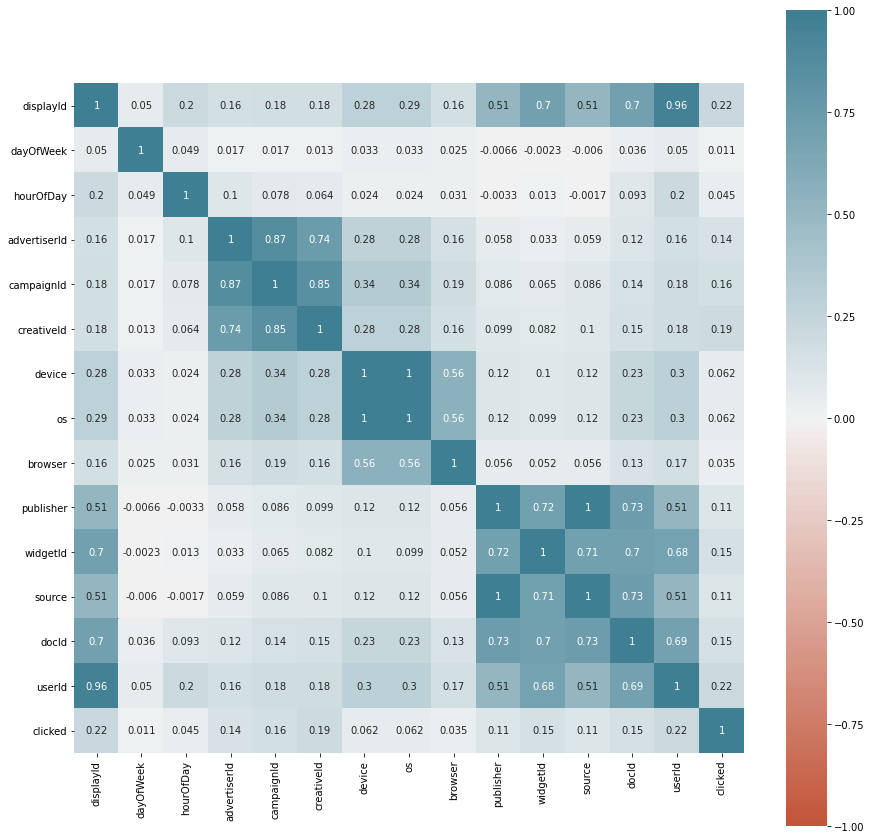

In [91]:
target_columns = ['displayId', 'dayOfWeek', 'hourOfDay',
                              'advertiserId', 'campaignId', 'creativeId', 
                              'publisher', 'widgetId', 'device', 'os', 
                              'browser', 'source', 'docId', 'userId']
display_columns = [
      'displayId', 'dayOfWeek', 'hourOfDay', 'advertiserId',
      'campaignId', 'creativeId', 'device', 'os',
      'browser', 'publisher', 'widgetId', 'source', 'docId', 'userId', 'clicked'
    ]
corrolation_heatmap(
    tranform_to_target_encoded(train_data, target_columns)[display_columns]
);

In this part, we going throw data to find outliers. When we have categorical data, we should group data to have numberical data to compare and find outliers.

For many fields, Some of the entries appears a few time in whole train-set. as mentioned before these data are outliers and we have to remove or replace them.

**Distribution of click and not click over day**

(array([ 39645.,  96966., 253126., 433928., 205604., 160823., 192473.,
        101612., 118448., 153973.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

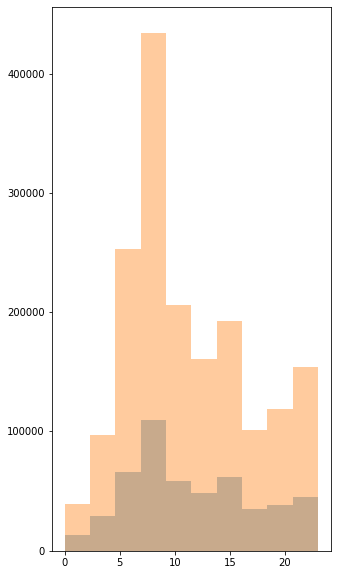

In [92]:
plt.figure(figsize=(5, 10))
plt.hist(train_data[train_data["clicked"] == 1].hourOfDay, alpha=0.4)
plt.hist(train_data[train_data["clicked"] == 0].hourOfDay, alpha=0.4)

**Data Per User Count** for remove inactive users

In [93]:
train_data.userId.value_counts()

163374     993
26033      917
8409       773
230821     530
327701     476
          ... 
2418482      2
745179       2
1249306      2
1443550      2
1951704      2
Name: userId, Length: 432126, dtype: int64

In [94]:
train_data.userId.value_counts().describe()

count    432126.000000
mean          5.234369
std           4.925206
min           2.000000
25%           3.000000
50%           4.000000
75%           6.000000
max         993.000000
Name: userId, dtype: float64

In [95]:
train_data.userId.value_counts().quantile(0.999)

39.0

**Corrolation between device and os**

In [96]:
train_data.groupby(["device", "os"]).count()

displayId  timestamp  dayOfWeek  ...    docId   userId  clicked
device os                                   ...                           
0      0     1428165    1428165    1428165  ...  1428165  1428165  1428165
       2       70440      70440      70440  ...    70440    70440    70440
       6          47         47         47  ...       47       47       47
1      1      732825     732825     732825  ...   732825   732825   732825
       3       13512      13512      13512  ...    13512    13512    13512
       4        2904       2904       2904  ...     2904     2904     2904
       5        6156       6156       6156  ...     6156     6156     6156
2      2        7532       7532       7532  ...     7532     7532     7532
3      6         326        326        326  ...      326      326      326

[9 rows x 14 columns]

**Corrolation between displayId and widgetId**

In [97]:
x = train_data.groupby("displayId")["widgetId"].nunique()
x

displayId
1115095    1
1132439    1
1159452    1
1159901    1
1172176    1
          ..
4706228    1
4706235    1
4706237    1
4706255    1
4706256    1
Name: widgetId, Length: 505309, dtype: int64

**Unique values of each columns** to approach in on hot encoding

In [98]:
for col in train_data.columns:
  unique_values = sorted(train_data[col].unique())
  print(col, len(unique_values))
  if len(unique_values) < 500:
    print(unique_values)

displayId 505309
timestamp 478168
dayOfWeek 7
[0, 1, 2, 3, 4, 5, 6]
hourOfDay 24
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
advertiserId 200
[1, 85, 100, 202, 258, 259, 269, 276, 290, 378, 433, 537, 857, 1153, 1209, 1274, 1349, 1383, 1386, 1419, 1481, 1539, 1651, 1662, 1701, 1711, 1730, 1925, 2003, 2064, 2167, 2186, 2294, 2396, 2418, 2505, 2737, 2846, 3004, 3043, 3045, 3064, 3073, 3091, 3096, 3116, 3137, 3216, 3240, 3257, 3344, 3358, 3370, 3377, 3409, 3456, 3543, 3649, 3767, 3847, 3972, 4015, 4089, 4107, 4187, 4252, 4264, 4434, 4439, 4472, 4532, 4705, 4726, 4794, 4971, 5027, 5090, 5124, 5175, 5180, 5184, 5189, 5234, 5300, 5302, 5354, 5399, 5421, 5427, 5432, 5433, 5513, 5528, 5569, 5593, 5687, 5887, 5962, 5971, 5979, 6009, 6011, 6018, 6040, 6129, 6184, 6222, 6394, 6409, 6568, 6572, 6578, 6620, 6642, 6686, 6698, 6733, 6783, 6795, 6828, 6835, 6883, 6931, 6956, 6959, 6961, 6967, 6973, 7140, 7166, 7194, 7291, 7315, 7357, 7498, 7554, 7579, 7626, 77

**Check ads from same advertiser in one display**

In [99]:
train_data.groupby(["displayId", "advertiserId", "publisher", "dayOfWeek", "hourOfDay"])[['clicked']].count()

clicked
displayId advertiserId publisher dayOfWeek hourOfDay         
1115095   4434         2         3         21               1
          5528         2         3         21               1
          6620         2         3         21               1
          9389         2         3         21               2
1132439   290          10        3         21               2
...                                                       ...
4706255   378          22        4         0                2
          5175         22        4         0                1
          6409         22        4         0                1
4706256   378          22        4         0                2
          5175         22        4         0                2

[1680788 rows x 1 columns]

## Result

Based on corrolations we can select one field from each group and drop all non-informative columns like displayId and timestamp.
The final fields to learn models will be obtained from model result on validation-set.

For removing outliers, We have to remove data entries which appeared less than $\tau$. $\tau$ is also comes from validation-set result. 20 is good for this parameter. 

`drop_non_informative_rows_by_columns` function drops entries which appears less than threshold

`fill_null_non_informative_rows_by_columns` function fill entries which appears less than threshold with NaN

`drop_equal_rows_by_max` function aggregates (max == 1) similar rows (after removing unique columns) to decrease dataset size

`drop_equal_rows_by_mean` function aggregates (mean > 0.5) similar rows (after removing unique columns) to decrease dataset size

In [100]:
def drop_non_informative_rows_by_columns(data, column, threshold):
  column_information = data[column].value_counts()
  informative_column_value = column_information[column_information > threshold].index
  return data[data[column].isin(informative_column_value)]

def fill_null_non_informative_rows_by_columns(data, column, threshold):
  data = data.copy()
  column_information = data[column].value_counts()
  informative_column_value = column_information[(column_information >= threshold)].index.astype(np.int)
  data[column] = data[column].apply(lambda x: x if x in informative_column_value else None)
  return data

def drop_equal_rows_by_max(data, columns):
  return data.groupby(columns)[['clicked']].max().reset_index()

def drop_equal_rows_by_mean(data, columns):
  return ((data.groupby(columns)[['clicked']].mean() > 0.5) * 1).reset_index()

In [185]:
fields = ["creativeId", "device", "widgetId", "hourOfDay", "publisher"]

In [125]:
clean_train_data = train_data
for field in fields:
  clean_train_data = drop_non_informative_rows_by_columns(clean_train_data, field, 20)
get_target_percentage(clean_train_data)

(2630216, 2042004, 588212, 0.22363638575691122)

# Balancing

We have to balance our train dataset. Many of classification models which trained on imbalance dayasets tends to predeic data always in major class. There are many ways to prevent this issue:

1. **Weighted Learning**: some models are support custom wieght classification. These models handle weights in their loss funnction.

2. **Balancing Train-Set**: In this method. we have to balance our data with oversampling or undersampling. Random oversampling/undersampling is the fastest and easiest way to balance the train-set. Samplings likes SMOTE, CNN, and ClusterCentroid does a preprocess on dataset and sample based on data.

3. **Ensamble Methods**: In ensemble we can train a model on different datasets and aggregate parameters. For this method, we have to split (or sample) our major class to and concat with minor class to have multi balance datasets and train models. 

Based on valiation and multiple running, we choose random undersampling to balance our data (Other methods does not improve the models.)

Another motication to undersampling is the time needs to train models. On the other hand, the undersampling methods satisfies the restiriction one click per advertisements group and the oversampling may break this restriction.

`undersample` function balances data using random undersampling

`oversample` function balances data using random oversampling

In [126]:
def _declassify(data):
  classes = data['clicked'].unique()
  res = []
  for c in classes:
    res.append(data[data['clicked'] == c])
  return res

def undersample(data):
  classes_data = _declassify(data)
  min_size = min(map(lambda x: len(x), classes_data))
  res = []
  for class_data in classes_data:
    res.append(class_data.sample(min_size))
  return pd.concat(res).sample(frac=1)

def oversample(data):
  classes_data = _declassify(data)
  min_size = max(map(lambda x: len(x), classes_data))
  res = []
  for class_data in classes_data:
    res.append(class_data.sample(min_size, replace=True))
  return pd.concat(res).sample(frac=1)

In [127]:
balance_train_data = clean_train_data
balance_train_data = undersample(balance_train_data)
get_target_percentage(balance_train_data)

(1176424, 588212, 588212, 0.5)

# Feature Extraction

As mentioned berfore, the dataset is categorical. One Hot Encoding works well beacause ids does not have any information as a sequencial numbers.

`get_datasets` function applyes one hot encoding on the given features and return in X, y format


In [223]:
def get_datasets(train_data, validation_data, test_data, features, one_hot_features):
  transformed_train = train_data[features]
  transformed_validation = validation_data[features]
  transformed_test = test_data[features]

  one_hot_encoder = preprocessing.OneHotEncoder(handle_unknown='ignore')
  one_hot_encoder.fit(transformed_train[one_hot_features].values)

  X_train = one_hot_encoder.transform(transformed_train[one_hot_features].values)
  X_validation = one_hot_encoder.transform(transformed_validation[one_hot_features].values)
  X_test = one_hot_encoder.transform(transformed_test[one_hot_features].values)

  transformed_train = transformed_train.drop(columns = one_hot_features)
  transformed_validation = transformed_validation.drop(columns = one_hot_features)
  transformed_test = transformed_test.drop(columns = one_hot_features)

  X_train = sp.sparse.hstack([X_train, transformed_train.values]).tocsr()
  X_validation = sp.sparse.hstack([X_validation, transformed_validation.values]).tocsr()
  X_test = sp.sparse.hstack([X_test, transformed_test.values]).tocsr()

  y_test = None
  y_train = train_data['clicked'].values
  y_validation = validation_data['clicked'].values
  if 'clicked' in test_data.columns:
    y_test = test_data['clicked'].values

  return X_train, y_train, X_validation, y_validation, X_test, y_test

In [129]:
X_train, y_train, X_validation, y_validation, X_test, y_test = get_datasets(
    balance_train_data, validation_data, test_data, 
    fields,
    fields,
)
X_train, X_validation, X_test

(<1176424x3676 sparse matrix of type '<class 'numpy.float64'>'
 	with 5882120 stored elements in Compressed Sparse Row format>,
 <753252x3676 sparse matrix of type '<class 'numpy.float64'>'
 	with 3763850 stored elements in Compressed Sparse Row format>,
 <753257x3676 sparse matrix of type '<class 'numpy.float64'>'
 	with 3763780 stored elements in Compressed Sparse Row format>)

# Metrics

## AUC: Area Under the ROC Curve

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

* True Positive Rate (recall)
* False Positive Rate

An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve.

AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).</br>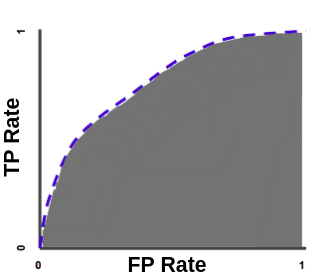

## Cross-Entropy Loss

Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A perfect model would have a log loss of 0. For two classes the loss is wrtiten in this syntax: -(y*log(p) + (1-y)*log(1-p)) 

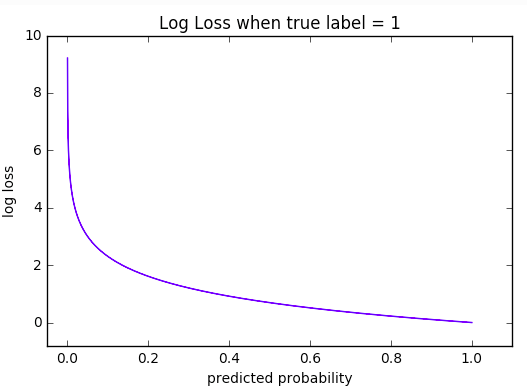

## F1 Score

Recall is the number of True Positives divided by the number of True Positives and the number of False Negatives. Put another way it is the number of positive predictions divided by the number of positive class values in the test data.

Precision is the number of True Positives divided by the number of True Positives and False Positives. Put another way, it is the number of positive predictions divided by the total number of positive class values predicted. 

The F1 Score is the 2*((precision*recall)/(precision+recall)). It is also called the F Score or the F Measure. Put another way, the F1 score conveys the balance between the precision and the recall. </br> 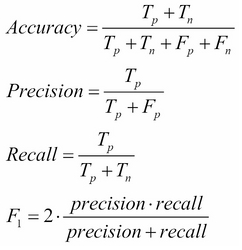

# Models

## Logistic Regression

In [130]:
setups = [
         {"penalty": "none"},
         {"C": 0.01},
         {"C": 0.1},
         {"C": 1},
         {"C": 10},
         {"C": 100},
]
scores = []

In [131]:
for setup in setups:
  print(setup)
  logreg = linear_model.LogisticRegression(max_iter=300, **setup)
  logreg.fit(X_train, y_train)

  y_pred_prob = logreg.predict_proba(X_validation)[:, 1]
  y_pred = logreg.predict(X_validation)

  scores.append({
      "AUC": roc_auc_score(y_validation, y_pred_prob),
      "Cross-entropy loss": log_loss(y_validation, y_pred_prob),
      "F1 score": f1_score(y_validation, y_pred),
  })

{'penalty': 'none'}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'C': 0.01}
{'C': 0.1}
{'C': 1}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'C': 10}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'C': 100}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [132]:
print("Logistic Regression")
print()

for setup, score in zip(setups, scores):
  print(f"{setup}:\t", end="")
  for t, v in score.items():
    print(f"{t}: {v}\t", end="")
  print()

Logistic Regression

{'penalty': 'none'}:	AUC: 0.6663157458710713	Cross-entropy loss: 0.6502838654297465	F1 score: 0.42240605603504033	
{'C': 0.01}:	AUC: 0.6608466891593722	Cross-entropy loss: 0.6538232285368591	F1 score: 0.41837317781893485	
{'C': 0.1}:	AUC: 0.6661188727221969	Cross-entropy loss: 0.6502873993542629	F1 score: 0.4221252169590854	
{'C': 1}:	AUC: 0.6663938943290366	Cross-entropy loss: 0.6500172946624231	F1 score: 0.42251819841655835	
{'C': 10}:	AUC: 0.6663293250869372	Cross-entropy loss: 0.6499812627319832	F1 score: 0.4224697440717897	
{'C': 100}:	AUC: 0.6663054267845306	Cross-entropy loss: 0.650312799477234	F1 score: 0.42253235441507514	


In [133]:
logreg = linear_model.LogisticRegression(max_iter=300, C=0.01)
logreg.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [134]:
y_pred_prob = logreg.predict_proba(X_train)[:, 1]
y_pred = logreg.predict(X_train)

print("Train:")
print('AUC:', roc_auc_score(y_train, y_pred_prob))
print('Cross-entropy loss:', log_loss(y_train, y_pred_prob))
print('F1 score:', f1_score(y_train, y_pred))
print('Predicted Clicked:', y_pred.sum())
print('Predicted Non-Clicked:', (1-y_pred).sum())
print()

Train:
AUC: 0.6624984104394233
Cross-entropy loss: 0.6526077719395093
F1 score: 0.6165368069629741
Predicted Clicked: 582667
Predicted Non-Clicked: 593757



In [135]:
y_pred_prob = logreg.predict_proba(X_validation)[:, 1]
y_pred = logreg.predict(X_validation)

print("Validation:")
print('AUC:', roc_auc_score(y_validation, y_pred_prob))
print('Cross-entropy loss:', log_loss(y_validation, y_pred_prob))
print('F1 score:', f1_score(y_validation, y_pred))
print('Predicted Clicked:', y_pred.sum())
print('Predicted Non-Clicked:', (1-y_pred).sum())
print()

Validation:
AUC: 0.6608466891593722
Cross-entropy loss: 0.6538232285368591
F1 score: 0.41837317781893485
Predicted Clicked: 325066
Predicted Non-Clicked: 428186



In [136]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
y_pred = logreg.predict(X_test)

print("Test:")
print('AUC:', roc_auc_score(y_test, y_pred_prob))
print('Cross-entropy loss:', log_loss(y_test, y_pred_prob))
print('F1 score:', f1_score(y_test, y_pred))
print('Predicted Clicked:', y_pred.sum())
print('Predicted Non-Clicked:', (1-y_pred).sum())
print()

Test:
AUC: 0.6618065670697987
Cross-entropy loss: 0.6531216882166047
F1 score: 0.41948956105178403
Predicted Clicked: 323376
Predicted Non-Clicked: 429881



## XGBoost

In [140]:
setups = [
          {"max_depth": 6},
          {"max_depth": 10},
          {"max_depth": 6, "lambda": 10},
          {"max_depth": 6, "lambda": 0.1},
          {"max_depth": 6, "lambda": 1},
]
scores = []

In [142]:
for setup in setups:
  print(setup)
  xgb = XGBClassifier(vebose=True, **setup)
  xgb.fit(X_train, y_train)

  y_pred_prob = xgb.predict_proba(X_validation)[:, 1]
  y_pred = xgb.predict(X_validation)

  scores.append({
      "AUC": roc_auc_score(y_validation, y_pred_prob),
      "Cross-entropy loss": log_loss(y_validation, y_pred_prob),
      "F1 score": f1_score(y_validation, y_pred),
  })

{'max_depth': 6}
{'max_depth': 10}
{'max_depth': 6, 'lambda': 10}
{'max_depth': 6, 'lambda': 0.1}
{'max_depth': 6, 'lambda': 1}


In [143]:
print("XGBoost")
print()

for setup, score in zip(setups, scores):
  print(f"{setup}:\t", end="")
  for t, v in score.items():
    print(f"{t}: {v}\t", end="")
  print()

XGBoost

{'max_depth': 6}:	AUC: 0.613017242884993	Cross-entropy loss: 0.6758619301634711	F1 score: 0.38552678229671394	
{'max_depth': 10}:	AUC: 0.613017242884993	Cross-entropy loss: 0.6758619301634711	F1 score: 0.38552678229671394	
{'max_depth': 6, 'lambda': 10}:	AUC: 0.6322265727758447	Cross-entropy loss: 0.6688268763659214	F1 score: 0.39549888902663477	
{'max_depth': 6, 'lambda': 0.1}:	AUC: 0.6469374871544797	Cross-entropy loss: 0.6622772926191749	F1 score: 0.4058697150269569	
{'max_depth': 6, 'lambda': 1}:	AUC: 0.6322265727758447	Cross-entropy loss: 0.6688268763659214	F1 score: 0.39549888902663477	


In [145]:
xgb = XGBClassifier(**{'max_depth': 6, 'lambda': 0.1})
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, lambda=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [146]:
y_pred_prob = xgb.predict_proba(X_train)[:, 1]
y_pred = xgb.predict(X_train)

print("Train:")
print('AUC:', roc_auc_score(y_train, y_pred_prob))
print('Cross-entropy loss:', log_loss(y_train, y_pred_prob))
print('F1 score:', f1_score(y_train, y_pred))
print('Predicted Clicked:', y_pred.sum())
print('Predicted Non-Clicked:', (1-y_pred).sum())
print()

Train:
AUC: 0.6346060013806505
Cross-entropy loss: 0.6683377211701974
F1 score: 0.6027984004389647
Predicted Clicked: 614618
Predicted Non-Clicked: 561806



In [147]:
y_pred_prob = xgb.predict_proba(X_validation)[:, 1]
y_pred = xgb.predict(X_validation)

print("Validation:")
print('AUC:', roc_auc_score(y_validation, y_pred_prob))
print('Cross-entropy loss:', log_loss(y_validation, y_pred_prob))
print('F1 score:', f1_score(y_validation, y_pred))
print('Predicted Clicked:', y_pred.sum())
print('Predicted Non-Clicked:', (1-y_pred).sum())
print()

Validation:
AUC: 0.6322265727758447
Cross-entropy loss: 0.6688268763659214
F1 score: 0.39549888902663477
Predicted Clicked: 355879
Predicted Non-Clicked: 397373



In [148]:
y_pred_prob = xgb.predict_proba(X_test)[:, 1]
y_pred = xgb.predict(X_test)

print("Test:")
print('AUC:', roc_auc_score(y_test, y_pred_prob))
print('Cross-entropy loss:', log_loss(y_test, y_pred_prob))
print('F1 score:', f1_score(y_test, y_pred))
print('Predicted Clicked:', y_pred.sum())
print('Predicted Non-Clicked:', (1-y_pred).sum())
print()

Test:
AUC: 0.6328903056390506
Cross-entropy loss: 0.6684000688278074
F1 score: 0.39601034355374953
Predicted Clicked: 354015
Predicted Non-Clicked: 399242



## Random Forest


In [ ]:
setups = [
          {"criterion": 'gini', 'n_estimators': 10},
          {"criterion": 'gini', 'n_estimators': 100},
          {"criterion": 'entropy', 'n_estimators': 10},
          {"criterion": 'entropy', 'n_estimators': 100},
]
scores = []

In [ ]:
for setup in setups:
  print(setup)
  rf = ensemble.RandomForestClassifier(verbose=True, n_jobs=-1, **setup)
  rf.fit(X_train[:100000], y_train[:100000])

  y_pred_prob = rf.predict_proba(X_validation)[:, 1]
  y_pred = rf.predict(X_validation)

  scores.append({
      "AUC": roc_auc_score(y_validation, y_pred_prob),
      "Cross-entropy loss": log_loss(y_validation, y_pred_prob),
      "F1 score": f1_score(y_validation, y_pred),
  })

{'criterion': 'gini', 'n_estimators': 10}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   36.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    3.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    3.6s finished


{'criterion': 'gini', 'n_estimators': 100}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   16.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   37.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   17.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   37.4s finished


{'criterion': 'entropy', 'n_estimators': 10}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   36.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    4.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    4.1s finished


{'criterion': 'entropy', 'n_estimators': 100}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   18.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   41.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   18.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   40.7s finished


In [ ]:
print("Random Forest")
print()

for setup, score in zip(setups, scores):
  print(f"{setup}:\t", end="")
  for t, v in score.items():
    print(f"{t}: {v}\t", end="")
  print()

Random Forest

{'criterion': 'gini', 'n_estimators': 10}:	AUC: 0.595814727965981	Cross-entropy loss: 1.8044915413224651	F1 score: 0.3701458853872814	
{'criterion': 'gini', 'n_estimators': 100}:	AUC: 0.6056502136964095	Cross-entropy loss: 0.8790980289847006	F1 score: 0.3826293170854341	
{'criterion': 'entropy', 'n_estimators': 10}:	AUC: 0.5947905298767263	Cross-entropy loss: 1.766285390859366	F1 score: 0.3704862229173375	
{'criterion': 'entropy', 'n_estimators': 100}:	AUC: 0.605137649782655	Cross-entropy loss: 0.8855108834192036	F1 score: 0.382130280125378	


In [ ]:
rf = ensemble.RandomForestClassifier(**{'criterion': 'gini', 'n_estimators': 100})
rf.fit(X_train[:100000], y_train[:100000])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred_prob = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)

print("Train:")
print('AUC:', roc_auc_score(y_train, y_pred_prob))
print('Cross-entropy loss:', log_loss(y_train, y_pred_prob))
print('F1 score:', f1_score(y_train, y_pred))
print('Predicted Clicked:', y_pred.sum())
print('Predicted Non-Clicked:', (1-y_pred).sum())
print()

Train:
AUC: 0.6463833094056199
Cross-entropy loss: 0.8220729103130521
F1 score: 0.6057888682364514
Predicted Clicked: 498334
Predicted Non-Clicked: 509604



In [ ]:
y_pred_prob = rf.predict_proba(X_validation)[:, 1]
y_pred = rf.predict(X_validation)

print("Validation:")
print('AUC:', roc_auc_score(y_validation, y_pred_prob))
print('Cross-entropy loss:', log_loss(y_validation, y_pred_prob))
print('F1 score:', f1_score(y_validation, y_pred))
print('Predicted Clicked:', y_pred.sum())
print('Predicted Non-Clicked:', (1-y_pred).sum())
print()

Validation:
AUC: 0.6052608893937095
Cross-entropy loss: 0.8799880522934367
F1 score: 0.38160340683498245
Predicted Clicked: 338310
Predicted Non-Clicked: 414942



In [ ]:
y_pred_prob = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)

print("Test:")
print('AUC:', roc_auc_score(y_test, y_pred_prob))
print('Cross-entropy loss:', log_loss(y_test, y_pred_prob))
print('F1 score:', f1_score(y_test, y_pred))
print('Predicted Clicked:', y_pred.sum())
print('Predicted Non-Clicked:', (1-y_pred).sum())
print()

Test:
AUC: 0.6073393074083611
Cross-entropy loss: 0.875924497932348
F1 score: 0.383864259904963
Predicted Clicked: 337472
Predicted Non-Clicked: 415785



## SVM

In [214]:
setups = [
          {"kernel": 'linear'},
          {"kernel": 'poly', "degree": 2},
          {"kernel": 'rbf'},
]
scores = []

In [215]:
for setup in setups:
  print(setup)
  svc = svm.SVC(verbose=True, probability=True, **setup)
  svc.fit(X_train[:10000], y_train[:10000])

  y_pred_prob = svc.predict_proba(X_validation[:10000])[:, 1]
  y_pred = svc.predict(X_validation[:10000])

  scores.append({
      "AUC": roc_auc_score(y_validation[:10000], y_pred_prob),
      "Cross-entropy loss": log_loss(y_validation[:10000], y_pred_prob),
      "F1 score": f1_score(y_validation[:10000], y_pred),
  })

{'kernel': 'linear'}
[LibSVM]{'kernel': 'poly', 'degree': 2}
[LibSVM]{'kernel': 'rbf'}
[LibSVM]

In [216]:
print("SVM")
print()

for setup, score in zip(setups, scores):
  print(f"{setup}:\t", end="")
  for t, v in score.items():
    print(f"{t}: {v}\t", end="")
  print()

SVM

{'kernel': 'linear'}:	AUC: 0.618081932914895	Cross-entropy loss: 0.6711445748763468	F1 score: 0.38295353654927494	
{'kernel': 'poly', 'degree': 2}:	AUC: 0.6267787288608972	Cross-entropy loss: 0.6677333262052446	F1 score: 0.3988629563135847	
{'kernel': 'rbf'}:	AUC: 0.6267253973655907	Cross-entropy loss: 0.6668343072960354	F1 score: 0.39636363636363636	


In [ ]:
svc = svm.SVC(probability=True, **{"kernel": 'rbf'})
svc.fit(X_train[:10000], y_train[:10000])

In [217]:
y_pred_prob = svc.predict_proba(X_train[:10000])[:, 1]
y_pred = svc.predict(X_train[:10000])

print("Train:")
print('AUC:', roc_auc_score(y_train[:10000], y_pred_prob))
print('Cross-entropy loss:', log_loss(y_train[:10000], y_pred_prob))
print('F1 score:', f1_score(y_train[:10000], y_pred))
print('Predicted Clicked:', y_pred.sum())
print('Predicted Non-Clicked:', (1-y_pred).sum())
print()

Train:
AUC: 0.8710081148144805
Cross-entropy loss: 0.5745376730403167
F1 score: 0.7728751525010166
Predicted Clicked: 4864
Predicted Non-Clicked: 5136



In [219]:
y_pred_prob = svc.predict_proba(X_validation[:10000])[:, 1]
y_pred = svc.predict(X_validation[:10000])

print("Validation:")
print('AUC:', roc_auc_score(y_validation[:10000], y_pred_prob))
print('Cross-entropy loss:', log_loss(y_validation[:10000], y_pred_prob))
print('F1 score:', f1_score(y_validation[:10000], y_pred))
print('Predicted Clicked:', y_pred.sum())
print('Predicted Non-Clicked:', (1-y_pred).sum())
print()

Validation:
AUC: 0.6267253973655907
Cross-entropy loss: 0.6668343072960354
F1 score: 0.39636363636363636
Predicted Clicked: 4355
Predicted Non-Clicked: 5645



In [221]:
y_pred_prob = svc.predict_proba(X_test[:10000])[:, 1]
y_pred = svc.predict(X_test[:10000])

print("Test:")
print('AUC:', roc_auc_score(y_test[:10000], y_pred_prob))
print('Cross-entropy loss:', log_loss(y_test[:10000], y_pred_prob))
print('F1 score:', f1_score(y_test[:10000], y_pred))
print('Predicted Clicked:', y_pred.sum())
print('Predicted Non-Clicked:', (1-y_pred).sum())
print()

Test:
AUC: 0.6258880900173607
Cross-entropy loss: 0.6697505756013971
F1 score: 0.39606616003576217
Predicted Clicked: 4466
Predicted Non-Clicked: 5534



In [ ]:
# we can compare it with a SVC,
from sklearn.svm import SVC
svc = SVC(probability=True)
svc.fit(X_train, y_train)
y_pred_prob = svc.predict_proba(X_test)[:, 1]
y_pred = svc.predict(X_test)

print("SVC")
print()
print('AUC:', roc_auc_score(y_test, y_pred_prob))
print('Cross-entropy loss:', log_loss(y_test, y_pred_prob))
print('F1 score:', f1_score(y_test, y_pred))
print('Predicted Clicked:', y_pred.sum())
print('Predicted Non-Clicked:', (1-y_pred).sum())

## Random

In [154]:
# we can compare it with a random,
y_pred_prob = np.array([np.random.rand() for _ in range(len(y_test))])
y_pred = y_pred_prob.round().astype(np.int)

print("Random")
print()
print('AUC:', roc_auc_score(y_test, y_pred_prob))
print('Cross-entropy loss:', log_loss(y_test, y_pred_prob))
print('F1 score:', f1_score(y_test, y_pred))
print('Predicted Clicked:', y_pred.sum())
print('Predicted Non-Clicked:', (1-y_pred).sum())

Random

AUC: 0.5003275837622146
Cross-entropy loss: 0.9988181518568756
F1 score: 0.30863537977716216
Predicted Clicked: 376265
Predicted Non-Clicked: 376992


# FM

## Theoretical Explanation


Factorization Machines are a general predictor working with any
real valued feature vector. They combine the advantages of Support Vector Machines (SVM) with factorization models. Like many other classification models, FM have a Model Equatoin that predicts the target based on the features for each data. The Model Equation for FM is as shown below:

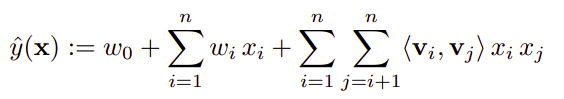

x<sub>i</sub> are features.<br/>
w<sub>0</sub> is the global bias.<br/>
w<sub>i</sub> models the strength of the i-th variable.<br/>
v<sub>i</sub> describes the i-th variable with k factors.<br/>

This model is very similar to SVM's prediction model wiht polynomial kernel of degree 2:

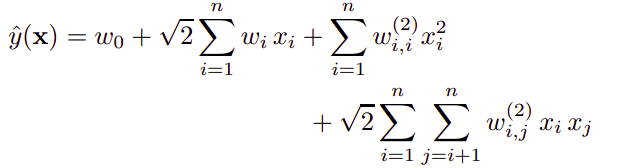

It considers a weight for x<sub>i</sub><sup>2</sup> which is set to zero in FM. <v<sub>i</sub>,v<sub>j</sub>> in FM coresponds to <w<sub>i</sub>,w<sub>j</sub>> in SVM which are the weight for x<sub>i</sub>x<sub>j</sub>. </br> 
But there are some important differences: 
1. In SVM weights for x<sub>i</sub>x<sub>j</sub> are independent from each other and each <w<sub>i</sub>,w<sub>j</sub>> is trained independently however in FM each weight for x<sub>i</sub>x<sub>j</sub> are correlated to each other. Although it seems that SVM has more parameters and more potential to learn better, but in CTR challenges that data consists of categorical fields and dataset is very sparse, there is not enough data for SVM to learn its many parameters. In FM each feature has a factorizatoin and the weights of two features interaction are calculated by the dot product of their factorization vector.  </br> 
So linear and Polynomial SVMs fail for very sparse problems. But FM can estimate its parameters under sparsity. </br> 

2. Another difference is that the number of parameters in FM is O(nk) and since k << n it is about O(n) which is the number of featuers. But in degree 2 polynomial SVM the number of parameters is O(n<sup>2</sup>) which is unacceptable since number of features in CTR challenges is large and (n<sup>2</sup>) could easily reach to tens of millions and this requiers a large memory.</br>

3. FM complexity in the first sight is O(kn<sup>2</sup>) but the model equation of a factorization machine can be computed in linear time as shown below:

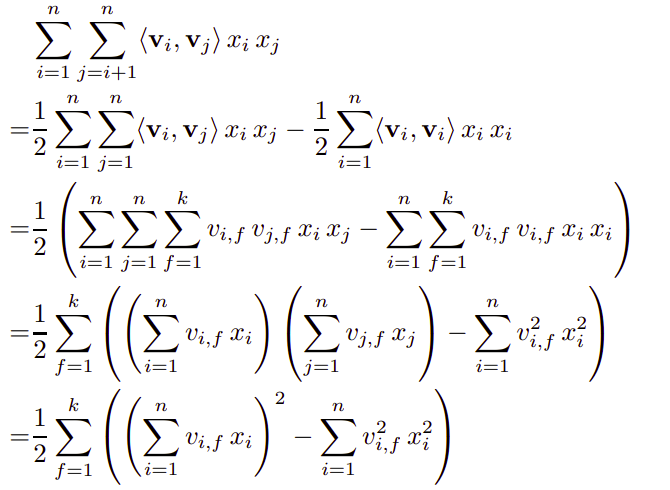

So the complexity drops to O(kn).</br>
Since FMs have a closed model equation that can be computed in linear time the model parameters (w0, w and V) of FMs can be learned efficiently by gradient descent methods for a variety of losses. The gradient of the FM model is:</br>


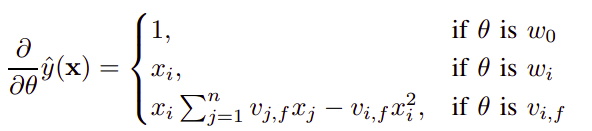

In conclusion, FMs model all interactions between variables using factorized parameters. Thus they are able to estimate interactions even in problems with huge sparsity. Model equation of FMs can be calculated in linear time
and thus FMs can be optimized directly.
</br>Alos the recomputed model equation is as shown below:

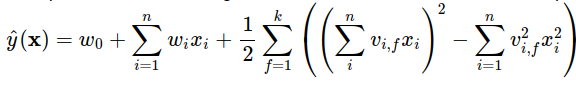

## Implementation

In this project we used the base code from [here](http://ethen8181.github.io/machine-learning/recsys/factorization_machine/factorization_machine.html#Factorization-Machine-(FM))

The used loss function is cross-entropy loss (log loss). In the dataset, target is labeled as one or zero. In the code zero is mapped to -1 so classes are 1 and -1. </br>
The original code had some bugs for example it did not save the changes on global bias and reset the changes in each iteration. This bug is fixed now. It now supports a two level learning, with two different learning rates.</br>
Log loss for classes 1 and -1:
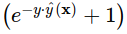

We use gradient descent with a Cross_Entropy loss. In each iteration we update the parameters base on the loss_gradient, equation_gradient and a learning rate. equation_gradients are discussed in the theoretical section, here we show the loss_gradient for cross_entropy.

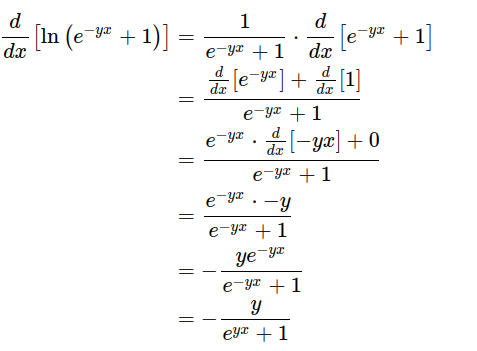

The code is fairly commented. But here we discuss some the most important tips.</br>
The iterative functions that are used in loop, are accelerated by Numba.
Numba translates Python functions to optimized machine code at runtime using the industry-standard LLVM compiler library.</br>
For updating the factorized parameters, 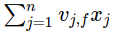 is indepentent from i and we calculate this only once for each factor. </br>
These tips improve the run time. We also throw in some L2 regularization to prevent overfitting and it is considerd in the gradient update role.

### Code

In [177]:
class FM(BaseEstimator, ClassifierMixin):
    """
    Factorization Machine [1]_ using Stochastic Gradient Descent.
    For binary classification only.

    Parameters
    ----------
    n_iter1 : int, default 10
        Number of iterations to train the algorithm with learning_rate1.

    n_iter2 : int, default 10
        Number of iterations to train the algorithm with learning_rate2.

    n_factors : int, default 10
        Number/dimension of features' latent factors.

    learning_rate1 : float, default 0.1
        Learning rate for the gradient descent optimizer for n_iter1 first iterations.

    learning_rate2 : float, default 0.1
        Learning rate for the gradient descent optimizer for n_iter2 second iterations.

    reg_coef : float, default 0.01
        Regularization strength for weights/coefficients.

    reg_factors : float, default 0.01
        Regularization strength for features' latent factors.

    random_state : int, default 1234
        Seed for the randomly initialized features latent factors

    verbose : bool, default True
        Whether to print progress bar while training.

    Attributes
    ----------
    intercept_ : double
        Intercept term, w0 based on the original notations.

    coef_ : 1d ndarray, shape [n_features,]
        Coefficients, w based on the original notations.

    feature_factors_ : 2d ndarray, shape [n_factors, n_features]
        Latent factors for all features. v based on the original
        notations. The learned factors can be viewed as the
        embeddings for each features. If a pair of features tends
        to co-occur often, then their embeddings should be
        close/similar (in terms of cosine similarity) to each other.

    history_ : list
        Loss function's history at each iteration, useful
        for evaluating whether the algorithm converged or not.

    References
    ----------
    .. [1] `S. Rendle Factorization Machines (2010)
            <http://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf>`_ 
    """

    def __init__(self, n_iter1 = 10, n_iter2 = 0, n_factors = 10,
                 learning_rate1 = 0.1, learning_rate2 = 0.1, reg_coef = 0.01,
                 reg_factors = 0.01, random_state = 1234, verbose = True):
        self.n_iter1 = n_iter1
        self.n_iter2 = n_iter2
        self.verbose = verbose
        self.reg_coef = reg_coef
        self.n_factors = n_factors
        self.reg_factors = reg_factors
        self.random_state = random_state
        self.learning_rate1 = learning_rate1
        self.learning_rate2 = learning_rate2

    def fit(self, X, y):
        """
        Fit the model to the input data and label.

        Parameters
        ----------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        y : 1d ndarray, shape [n_samples,]
            Training data's corresponding label.

        Returns
        -------
        self
        """

        n_samples, n_features = X.shape
        self.coef_ = np.zeros(n_features)
        self.intercept_ = 0.0

        # the factors are often initialized with a mean of 0 and standard deviation
        # of 1 / sqrt(number of latent factor specified)
        np.random.seed(self.random_state)
        self.feature_factors_ = np.random.normal(
            scale = 1 / np.sqrt(self.n_factors), size = (self.n_factors, n_features))
        
        # the gradient is implemented in a way that requires
        # the negative class to be labeled as -1 instead of 0
        y = y.copy().astype(np.int32)
        y[y == 0] = -1

        loop = range(self.n_iter1 + self.n_iter2)
        if self.verbose:
            loop = trange(self.n_iter1 + self.n_iter2)

        self.history_ = []
        for i in loop:
            if i < self.n_iter1:
                learning_rate = self.learning_rate1
            else:
                learning_rate = self.learning_rate2
            loss, self.intercept_ = _sgd_update(X.data, X.indptr, X.indices,
                               y, n_samples, n_features,
                               self.intercept_, self.coef_,
                               self.feature_factors_, self.n_factors,
                               learning_rate, self.reg_coef, self.reg_factors)
            self.history_.append(loss)

        return self

    def predict_proba(self, X):
        """
        Probability estimates. The returned estimates for
        all classes are ordered by the label of classes.

        Paramters
        ---------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        Returns
        -------
        proba : 2d ndarray, shape [n_samples, n_classes]
            The probability of the sample for each class in the model.
        """
        pred = self._predict(X)
        pred_proba = 1.0 / (1.0 + np.exp(-pred))
        proba = np.vstack((1 - pred_proba, pred_proba)).T
        return proba

    def _predict(self, X):
        """Similar to _predict_instance but vectorized for all samples"""
        linear_output = X * self.coef_
        v = self.feature_factors_.T
        term = (X * v) ** 2 - (X.power(2) * (v ** 2))
        factor_output = 0.5 * np.sum(term, axis = 1)
        return self.intercept_ + linear_output + factor_output

    def predict(self, X):
        """
        Predict class labels for samples in X.

        Parameters
        ----------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        Returns
        -------
        Predicted class label per sample.
        """
        pred_proba = self.predict_proba(X)[:, 1]
        return pred_proba.round().astype(np.int)

    def predict_group_(self, X):
        """
        Predict class labels for samples in X.
        Only samples with highest prob classify as 1

        Parameters
        ----------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        Returns
        -------
        Predicted class label per sample.
        """
        pred_proba = self.predict_proba(X)[:, 1]        
        pred_proba_max = pred_proba.max()
        return (pred_proba == pred_proba_max).astype(np.int)

    def predict_groups(self, X):
        """
        Predict class labels for samples in X.
        Only samples with highest prob classify as 1

        Parameters
        ----------
        X : list of scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        Returns
        -------
        Predicted class label per sample.
        """
        result = []
        for x in X:
            result.append(self.predict_group_(x))
            
        return result


@njit
def _sgd_update(data, indptr, indices, y, n_samples, n_features,
                w0, w, v, n_factors, learning_rate, reg_w, reg_v):
    """
    Compute the loss of the current iteration and update
    gradients accordingly.
    """
    loss = 0.0
    for i in range(n_samples):
        pred, summed = _predict_instance(data, indptr, indices, w0, w, v, n_factors, i)
        
        # calculate loss and its gradient
        loss += _log_loss(pred, y[i])
        loss_gradient = -y[i] / (np.exp(y[i] * pred) + 1.0)
    
        # update bias/intercept term
        w0 -= learning_rate * loss_gradient

        # update weight
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            w[feature] -= learning_rate * (loss_gradient * data[index] + 2 * reg_w * w[feature])

        # update factor
        for factor in range(n_factors):
            for index in range(indptr[i], indptr[i + 1]):
                feature = indices[index]
                term = summed[factor] - v[factor, feature] * data[index]
                v_gradient = loss_gradient * data[index] * term
                v[factor, feature] -= learning_rate * (v_gradient + 2 * reg_v * v[factor, feature])

    loss /= n_samples
    return loss, w0


@njit
def _predict_instance(data, indptr, indices, w0, w, v, n_factors, i):
    """predicting a single instance"""
    summed = np.zeros(n_factors)
    summed_squared = np.zeros(n_factors)

    # linear output w * x
    pred = w0
    for index in range(indptr[i], indptr[i + 1]):
        feature = indices[index]
        pred += w[feature] * data[index]

    # factor output
    for factor in range(n_factors):
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            term = v[factor, feature] * data[index]
            summed[factor] += term
            summed_squared[factor] += term * term

        pred += 0.5 * (summed[factor] * summed[factor] - summed_squared[factor])
    
    # summed is the independent term that can be re-used
    # during the gradient update stage
    return pred, summed


@njit
def _log_loss(pred, y):
    """
    negative log likelihood of the
    current prediction and label, y.
    """
    return np.log(np.exp(-pred * y) + 1.0)

### Run

In [206]:
setups = [
          {"n_iter1": 250, "learning_rate1": 0.01, "n_factors": 10, "reg_coef": 0.0001, "reg_factors": 0.0001},
          {"n_iter1": 250, "learning_rate1": 0.001, "n_factors": 10, "reg_coef": 0.0001, "reg_factors": 0.0001},
          {"n_iter1": 250, "learning_rate1": 0.0005, "n_factors": 10, "reg_coef": 0.0001, "reg_factors": 0.0001},
          {"n_iter1": 250, "learning_rate1": 0.001, "n_factors": 10, "reg_coef": 0.00005, "reg_factors": 0.00005},
          {"n_iter1": 250, "learning_rate1": 0.001, "n_factors": 10, "reg_coef": 0.00001, "reg_factors": 0.00001},
          {"n_iter1": 250, "learning_rate1": 0.001, "n_factors": 5, "reg_coef": 0.0001, "reg_factors": 0.0001},
          {"n_iter1": 250, "learning_rate1": 0.001, "n_factors": 15, "reg_coef": 0.0001, "reg_factors": 0.0001},
]
scores = []

In [ ]:
for setup in setups:
  print(setup)
  fm = FM(**setup)
  fm.fit(X_train, y_train)

  y_pred_prob = fm.predict_proba(X_validation)[:, 1]
  y_pred = fm.predict(X_validation)

  scores.append({
      "AUC": roc_auc_score(y_validation, y_pred_prob),
      "Cross-entropy loss": log_loss(y_validation, y_pred_prob),
      "F1 score": f1_score(y_validation, y_pred),
      "history": fm.history_
  })

In [207]:
print("FM")
print()

for setup, score in zip(setups, scores):
  print(f"{setup}:\t", end="")
  for t, v in score.items():
    if t != "history":
      print(f"{t}: {v}\t", end="")
  print()

FM

{'n_iter1': 250, 'learning_rate1': 0.01, 'n_factors': 10, 'reg_coef': 0.0001, 'reg_factors': 0.0001}:	AUC: 0.6703423901300878	Cross-entropy loss: 0.6670579362203352	F1 score: 0.4256467637913488	
{'n_iter1': 250, 'learning_rate1': 0.001, 'n_factors': 10, 'reg_coef': 0.0001, 'reg_factors': 0.0001}:	AUC: 0.6839538206859197	Cross-entropy loss: 0.650419057760876	F1 score: 0.4345623847525192	
{'n_iter1': 250, 'learning_rate1': 0.0005, 'n_factors': 10, 'reg_coef': 0.0001, 'reg_factors': 0.0001}:	AUC: 0.6829981536446961	Cross-entropy loss: 0.6453099861539002	F1 score: 0.433647273635257	
{'n_iter1': 250, 'learning_rate1': 0.001, 'n_factors': 10, 'reg_coef': 5e-05, 'reg_factors': 5e-05}:	AUC: 0.6839181922994051	Cross-entropy loss: 0.6506558001871461	F1 score: 0.4344770123948464	
{'n_iter1': 250, 'learning_rate1': 0.001, 'n_factors': 10, 'reg_coef': 1e-05, 'reg_factors': 1e-05}:	AUC: 0.6838835462276533	Cross-entropy loss: 0.6509072690845092	F1 score: 0.43442342894336505	
{'n_iter1': 250, 'lea

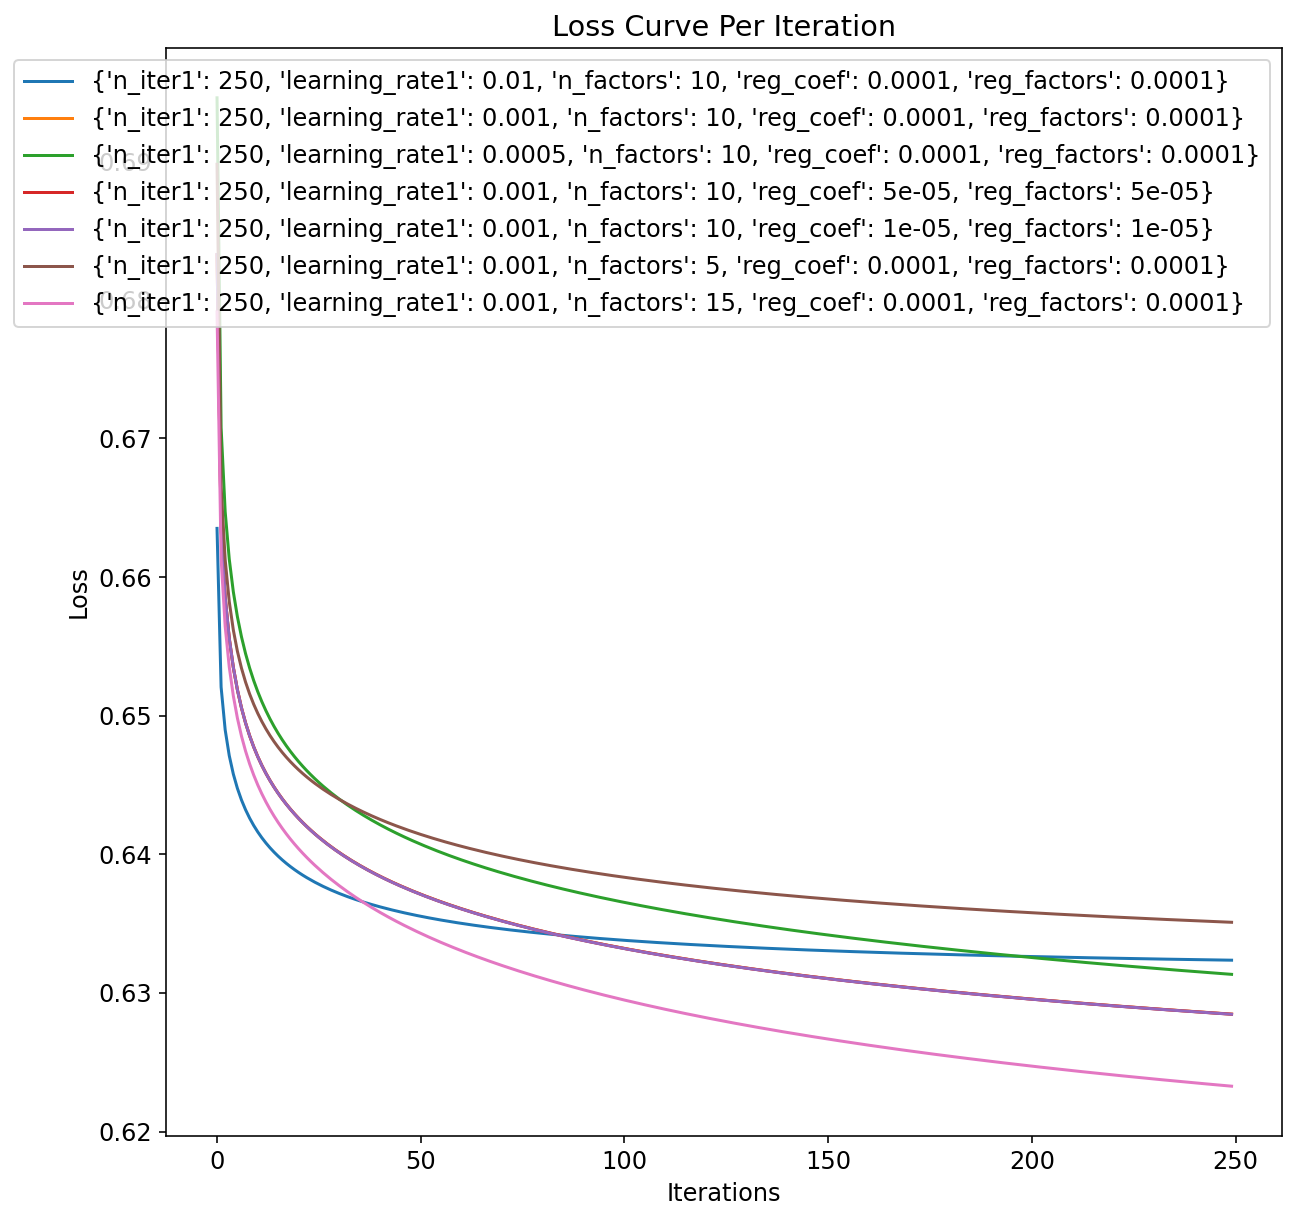

In [208]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['font.size'] = 12

for setup, score in zip(setups, scores):
  plt.plot(score['history'], label=f"{setup}")
plt.title('Loss Curve Per Iteration')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()



In [213]:
fm_setup = setup
fm_scores = scores

In [ ]:
fm = FM(**{"n_iter1": 250, "learning_rate1": 0.001, "n_factors": 15, "reg_coef": 0.0001, "reg_factors": 0.0001})
fm.fit(X_train, y_train)

In [210]:
y_pred_prob = fm.predict_proba(X_train)[:, 1]
y_pred = fm.predict(X_train)

print("Train:")
print('AUC:', roc_auc_score(y_train, y_pred_prob))
print('Cross-entropy loss:', log_loss(y_train, y_pred_prob))
print('F1 score:', f1_score(y_train, y_pred))
print('Predicted Clicked:', y_pred.sum())
print('Predicted Non-Clicked:', (1-y_pred).sum())
print()

Train:
AUC: 0.7060705934349485
Cross-entropy loss: 0.622445508575549
F1 score: 0.6604754756227984
Predicted Clicked: 634816
Predicted Non-Clicked: 541608



In [211]:
y_pred_prob = fm.predict_proba(X_validation)[:, 1]
y_pred = fm.predict(X_validation)

print("Validation:")
print('AUC:', roc_auc_score(y_validation, y_pred_prob))
print('Cross-entropy loss:', log_loss(y_validation, y_pred_prob))
print('F1 score:', f1_score(y_validation, y_pred))
print('Predicted Clicked:', y_pred.sum())
print('Predicted Non-Clicked:', (1-y_pred).sum())
print()

Validation:
AUC: 0.6864394102004235
Cross-entropy loss: 0.6502423094895688
F1 score: 0.4367595419847328
Predicted Clicked: 355564
Predicted Non-Clicked: 397688



In [212]:
y_pred_prob = fm.predict_proba(X_test)[:, 1]
y_pred = fm.predict(X_test)

print("Test:")
print('AUC:', roc_auc_score(y_test, y_pred_prob))
print('Cross-entropy loss:', log_loss(y_test, y_pred_prob))
print('F1 score:', f1_score(y_test, y_pred))
print('Predicted Clicked:', y_pred.sum())
print('Predicted Non-Clicked:', (1-y_pred).sum())
print()

Test:
AUC: 0.6871886066667774
Cross-entropy loss: 0.649379288531316
F1 score: 0.4371739708038406
Predicted Clicked: 354715
Predicted Non-Clicked: 398542



# FwFM

## Theoretical Explanation

The data involved in CTR prediction are typically multi-field categorical data, i.e., every feature is categorical and belongs to one and only one field. One of the interesting characteristics of such data is that features from one field often interact differently with features from different other fields.

For classificatoin in this project we use cross_entropy loss with L2 regularization.</br>
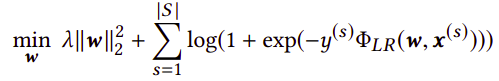

where S is number of samples and Φ<sub>LR</sub> is an LR model. We have already discussed Φ<sub>Poly2</sub> and Φ<sub>FM</sub>.</br>
Φ<sub>LR</sub> fials to learn the interaction between features while Φ<sub>Poly2</sub> tries to learn features interaction but fails in sparsity. Φ<sub>FM</sub> learns features interactions successfully even under sparse situation but it does not learn the field interactoins.</br>
Φ<sub>FFM</sub> is Field Aware Factorization Machine that take field interaction into condideratoin but it has too many parameters, O(mnk) where m is number of features, n is number of fields and k is the dimension of factorized vectors. </br>
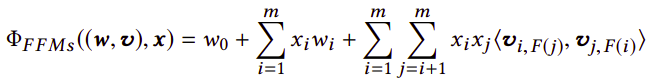

Feild Weighted Facotization Machines (FwFMs) use fewer parameters to consider field interactions. FwFM uses a field-weight that corresponds to the interaction between each feilds. So with n fields, there are n(n-1)/2 parameters which is fine because usually n << m. Also we would never need a weight from a field to itself because in each field, there is only one active feature so if field(i) == field(j) then x<sub>i</sub>x<sub>j</sub> is zero.</br>
The model equation of FwFM is as shown below:</br>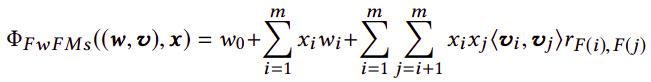

r<sub>F(i),F(j)</sub> is field interaction weight between F(i) and F(j).

FwFMs are extensions of FMs in the sense that we use additional weight r<sub>F(i),F(j)</sub>
to explicitly capture different interaction strengths of different field pairs. FFMs can model this implicitly however, the model complexity of FFMs is significantly higher than that of FMs and FwFMs.</br>
The number of parameters for FM, FFM and FwFM (m: features, n: fields, k: factor):</br>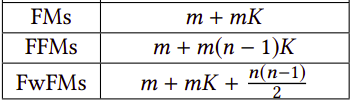

The mentioned FwFM model has a Linear Term in the form of x<sub>i</sub>w<sub>i</sub>. There are other options available e.g we could use a weight as <v<sub>i</sub>,w<sub>F(i)</sub>> as v<sub>i</sub> best describes each feature and w<sub>F(i)</sub> corresponds to its field. So this Linear Term can be used with the total parameters of nK + mK + n(n-1)/2.</br>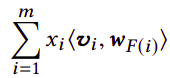

When it comes to model complexity, FwFM is a powerfull tool. It can be solved by Gradient Desent methods with the computational complexity of O(n<sup>2</sup>K). Since both n (number of fields) and K (number of factors) are usually small, FwFM has a good run time.

## Implementaion



Most of the implementation are based on Deep Networks and are written in TensorFlow.</br>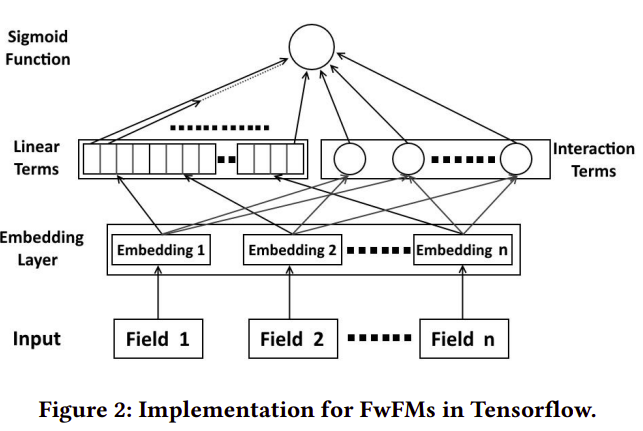 

We update the code for FM so it could be used for FwFM. 

* There are several Loss Functions that could be used for classification. In this implementation we use cross-entropy loss, like in the FM case. So we have the same loss_gradient as FM.</br>

* There are several options for Linear Term in FwFM. We use the simplest one which is the same as FM so gradient_loss for these parameters are the same as FM.</br>

* The gradient for factor parameters are changed and field weights are involved in calculating them.

* there are n(n-1)/2 new parameters for field weights. the gradient of r<sub>F(i),F(j)</sub> is the sum of feature intractions in FM.

By using the Sparse Matrix, we could easily use the sparsity to drop the order from O(m<sup>2</sup>K) to O(n<sup>2</sup>K). We also initialze factors and firld wieght with a normal distribution with mean zero.</br>

So by calculating gradient for each parameter, we leverage from the GD methods. We also use L2 regularization for all parameters except for w<sub>0</sub> which is the global bias.

### Code

The main code for updating field weights is as below:


for i in range(X.indptr[0],X.indptr[0 + 1]):</br>
    for j in range(i+1,X.indptr[0 + 1]):</br>
        r_fields[get_r_index(fields, X.indices[i], X.indices[j])] = X.data[i] * X.data[j] * feature_factor_dot(feature_factors_, X.indice[i], X.indices[j])


But because of using numba for accelerating we should not use any function or fancy data structure so the code is a little more in lines.

In [ ]:
class FwFM(BaseEstimator, ClassifierMixin):
    """
    Factorization Machine [1]_ using Stochastic Gradient Descent.
    For binary classification only.

    Parameters
    ----------
    n_iter1 : int, default 10
        Number of iterations to train the algorithm with learning_rate1.

    n_iter2 : int, default 10
        Number of iterations to train the algorithm with learning_rate2.

    n_factors : int, default 10
        Number/dimension of features' latent factors.

    learning_rate1 : float, default 0.1
        Learning rate for the gradient descent optimizer for n_iter1 first iterations.

    learning_rate2 : float, default 0.1
        Learning rate for the gradient descent optimizer for n_iter2 second iterations.

    reg_coef : float, default 0.01
        Regularization strength for weights/coefficients.

    reg_factors : float, default 0.01
        Regularization strength for features' latent factors.

    reg_field_weights : float, default 0.01
        Regularization strength for field weights.
    
    random_state : int, default 1234
        Seed for the randomly initialized features latent factors

    verbose : bool, default True
        Whether to print progress bar while training.

    Attributes
    ----------
    intercept_ : double
        Intercept term, w0 based on the original notations.

    coef_ : 1d ndarray, shape [n_features,]
        Coefficients, w based on the original notations.

    feature_factors_ : 2d ndarray, shape [n_factors, n_features]
        Latent factors for all features. v based on the original
        notations. The learned factors can be viewed as the
        embeddings for each features. If a pair of features tends
        to co-occur often, then their embeddings should be
        close/similar (in terms of cosine similarity) to each other.

    history_ : list
        Loss function's history at each iteration, useful
        for evaluating whether the algorithm converged or not.

    References
    ----------
    .. [1] `S. Rendle Factorization Machines (2010)
            <http://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf>`_ 
    """

    def __init__(self, n_iter1 = 10, n_iter2 = 0, n_factors = 10,
                 learning_rate1 = 0.1, learning_rate2 = 0.1, reg_coef = 0.01,
                 reg_factors = 0.01, reg_field_weights = 0.01, random_state = 1234, verbose = True):
        self.n_iter1 = n_iter1
        self.n_iter2 = n_iter2
        self.verbose = verbose
        self.reg_coef = reg_coef
        self.n_factors = n_factors
        self.reg_factors = reg_factors
        self.reg_field_weights = reg_field_weights
        self.random_state = random_state
        self.learning_rate1 = learning_rate1
        self.learning_rate2 = learning_rate2

    def fit(self, X, y, fields):
        """
        Fit the model to the input data and label.

        Parameters
        ----------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        y : 1d ndarray, shape [n_samples,]
            Training data's corresponding label.

        fields: 1d ndarray, shape [n_fields,]
            Last feature number for each fields.
            
        Returns
        -------
        self
        """


        self.fields = fields
        self.n_fields = len(fields)

        n_samples, n_features = X.shape
        self.coef_ = np.zeros(n_features)
        self.intercept_ = 0.0

        # the factors are often initialized with a mean of 0 and standard deviation
        # of 1 / sqrt(number of latent factor specified)
        np.random.seed(self.random_state)
        self.feature_factors_ = np.random.normal(
            scale = 1 / np.sqrt(self.n_factors), size = (self.n_factors, n_features))
        
        # the field weights are often initialized with a mean of 0 and standard deviation
        # of 1 / sqrt(number of latent factor specified)
        self.r_fields = np.random.normal(
            scale = 1 / np.sqrt(self.n_fields), size = (self.n_fields, self.n_fields))
        for i in range(self.n_fields):
            self.r_fields[i, i] = 0
        
        # the gradient is implemented in a way that requires
        # the negative class to be labeled as -1 instead of 0
        y = y.copy().astype(np.int32)
        y[y == 0] = -1

        loop = range(self.n_iter1 + self.n_iter2)
        if self.verbose:
            loop = trange(self.n_iter1 + self.n_iter2)

        self.history_ = []
        for i in loop:
            if i < self.n_iter1:
                learning_rate = self.learning_rate1
            else:
                learning_rate = self.learning_rate2
            loss, self.intercept_ = _sgd_update(X.data, X.indptr, X.indices,
                               y, n_samples, n_features,
                               self.intercept_, self.coef_,
                               self.feature_factors_, self.r_fields, self.n_factors, self.fields,
                               learning_rate, self.reg_coef, self.reg_factors, self.reg_field_weights)
            self.history_.append(loss)

        return self

    def predict_proba(self, X):
        """
        Probability estimates. The returned estimates for
        all classes are ordered by the label of classes.

        Paramters
        ---------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        Returns
        -------
        proba : 2d ndarray, shape [n_samples, n_classes]
            The probability of the sample for each class in the model.
        """
        pred = self._predict(X)
        pred_proba = 1.0 / (1.0 + np.exp(-pred))
        proba = np.vstack((1 - pred_proba, pred_proba)).T
        return proba

    def _predict(self, X):
        """Similar to _predict_instance but vectorized for all samples"""
        linear_output = X * self.coef_
        v = self.feature_factors_.T
        term = (X * v) ** 2 - (X.power(2) * (v ** 2))
        factor_output = 0.5 * np.sum(term, axis = 1)
        return self.intercept_ + linear_output + factor_output

    def predict(self, X):
        """
        Predict class labels for samples in X.

        Parameters
        ----------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        Returns
        -------
        Predicted class label per sample.
        """
        pred_proba = self.predict_proba(X)[:, 1]
        return pred_proba.round().astype(np.int)

    def predict_group_(self, X):
        """
        Predict class labels for samples in X.
        Only samples with highest prob classify as 1

        Parameters
        ----------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        Returns
        -------
        Predicted class label per sample.
        """
        pred_proba = self.predict_proba(X)[:, 1]        
        pred_proba_max = pred_proba.max()
        return (pred_proba == pred_proba_max).astype(np.int)

    def predict_groups(self, X):
        """
        Predict class labels for samples in X.
        Only samples with highest prob classify as 1

        Parameters
        ----------
        X : list of scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        Returns
        -------
        Predicted class label per sample.
        """
        result = []
        for x in X:
            result.append(self.predict_group_(x))
            
        return result



@njit
def _sgd_update(data, indptr, indices, y, n_samples, n_features,
                w0, w, v, r, n_factors, fields, learning_rate, reg_w, reg_v, reg_r):
    """
    Compute the loss of the current iteration and update
    gradients accordingly.
    """

    loss = 0.0
    for i in range(n_samples):
        pred = _predict_instance(data, indptr, indices, w0, w, v, r, fields, n_factors, i)
        
        # calculate loss and its gradient
        loss += _log_loss(pred, y[i])
        loss_gradient = -y[i] / (np.exp(y[i] * pred) + 1.0)
    
        # update bias/intercept term
        w0 -= learning_rate * loss_gradient

        # update weight
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            w[feature] -= learning_rate * (loss_gradient * data[index] + 2 * reg_w * w[feature])

        # update factor
        for factor in range(n_factors):
            for s in range(indptr[i], indptr[i + 1]):
                term = 0
                for t in range(indptr[i], indptr[i + 1]):
                    lo = 0
                    hi = len(fields)
                    while lo < hi:
                        mid = (lo + hi) // 2
                        if indices[s] < fields[mid]:
                            hi = mid
                        else:
                            lo = mid + 1
                    field1 = lo
                    lo = 0
                    hi = len(fields)
                    while lo < hi:
                        mid = (lo + hi) // 2
                        if indices[t] < fields[mid]:
                            hi = mid
                        else:
                            lo = mid + 1
                    field2 = lo        
                    if field1 > field2:
                        field2, field1 = field1, field2
                    term += v[factor, indices[t]] * data[t] * r[field1, field2]
                v_gradient = loss_gradient * data[s] * term
                v[factor, indices[s]] -= learning_rate * (v_gradient + 2 * reg_v * v[factor, indices[s]])

        # update field weights
        for s in range(indptr[i],indptr[i + 1]):
            for t in range(s + 1,indptr[i + 1]):
                lo = 0
                hi = len(fields)
                while lo < hi:
                    mid = (lo + hi) // 2
                    if indices[s] < fields[mid]:
                        hi = mid
                    else:
                        lo = mid + 1
                field1 = lo
                lo = 0
                hi = len(fields)
                while lo < hi:
                    mid = (lo + hi) // 2
                    if indices[t] < fields[mid]:
                        hi = mid
                    else:
                        lo = mid + 1
                field2 = lo        
                if field1 > field2:
                    field2, field1 = field1, field2
                
                factor_dot = 0
                for k in range(n_factors):
                    factor_dot += v[k, indices[s]] * v[k, indices[t]]
                r_gradient = loss_gradient * data[s] * data[t] * factor_dot
                r[field1, field2] -= learning_rate * (r_gradient + 2 * reg_r * r[field1, field2])

    loss /= n_samples
    return loss, w0


@njit
def _predict_instance(data, indptr, indices, w0, w, v, r, fields, n_factors, i):
    """predicting a single instance"""
    summed = np.zeros(n_factors)
    summed_squared = np.zeros(n_factors)

    # linear output w * x
    pred = w0
    for index in range(indptr[i], indptr[i + 1]):
        feature = indices[index]
        pred += w[feature] * data[index]

    # factor field_weighted output
    for s in range(indptr[i],indptr[i + 1]):
        for t in range(s + 1,indptr[i + 1]):
            lo = 0
            hi = len(fields)
            while lo < hi:
                mid = (lo + hi) // 2
                if indices[s] < fields[mid]:
                    hi = mid
                else:
                    lo = mid + 1
            field1 = lo
            lo = 0
            hi = len(fields)
            while lo < hi:
                mid = (lo + hi) // 2
                if indices[t] < fields[mid]:
                    hi = mid
                else:
                    lo = mid + 1
            field2 = lo        
            if field1 > field2:
                field2, field1 = field1, field2          
            factor_dot = 0
            for k in range(n_factors):
                factor_dot += v[k, indices[s]] * v[k, indices[t]]
            pred += data[s] * data[t] * factor_dot * r[field1, field2]

    return pred


@njit
def _log_loss(pred, y):
    """
    negative log likelihood of the
    current prediction and label, y.
    """
    return np.log(np.exp(-pred * y) + 1.0)

### Run

In [ ]:
sum = 0
fields_count = []
for field in fields:
  sum += len(balance_train_data[field].unique())
  fields_count.append(sum)
fields_count = np.array(fields_count)

In [ ]:
fwfm = FwFM(n_iter1 = 200, learning_rate1 = 0.0005, n_factors=10, reg_coef=0.0001, reg_factors=0.0001, reg_field_weights=0.0001)
fwfm.fit(X_train, y_train, fields_count)


100%|██████████| 200/200 [17:30<00:00,  5.25s/it]


FwFM(learning_rate1=0.0005, learning_rate2=0.1, n_factors=10, n_iter1=200,
     n_iter2=0, random_state=1234, reg_coef=0.0001, reg_factors=0.0001,
     reg_field_weights=0.0001, verbose=True)

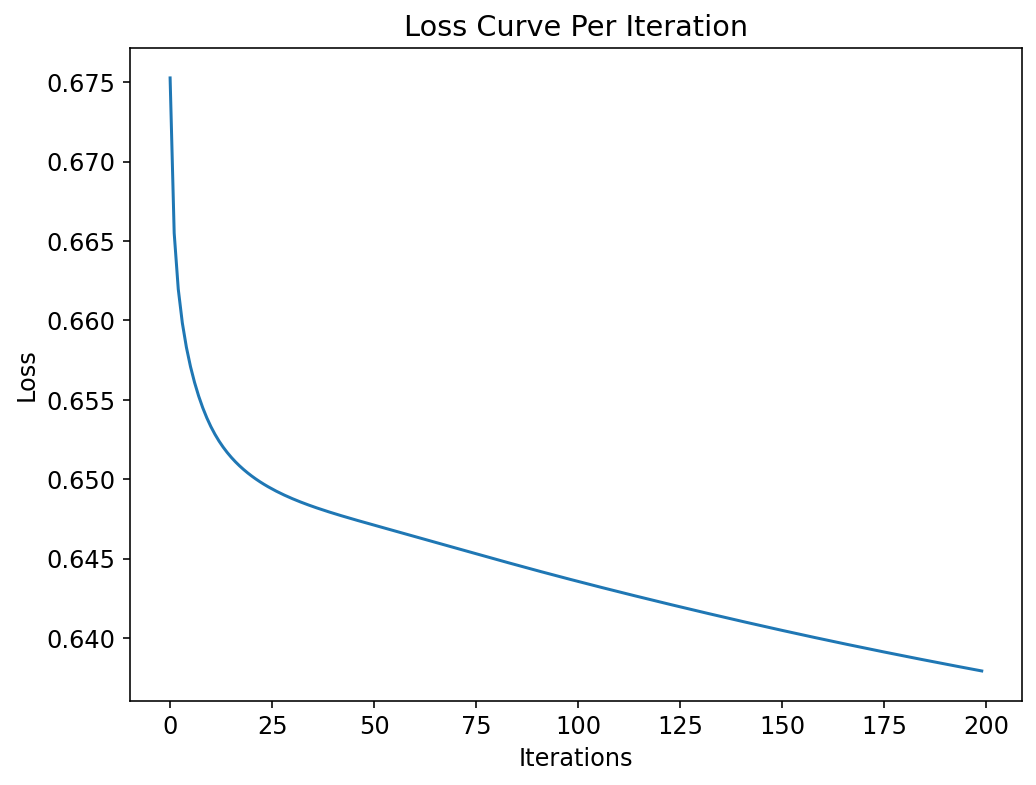

In [ ]:
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

plt.plot(fwfm.history_)
plt.title('Loss Curve Per Iteration')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [ ]:
print(fwfm)

print("Field Weighted Factorization Machine")
print()

FwFM(learning_rate1=0.0005, learning_rate2=0.1, n_factors=10, n_iter1=200,
     n_iter2=0, random_state=1234, reg_coef=0.0001, reg_factors=0.0001,
     reg_field_weights=0.0001, verbose=True)
Field Weighted Factorization Machine



In [ ]:
y_pred_prob = fwfm.predict_proba(X_train)[:, 1]
y_pred = fwfm.predict(X_train)

print("Train:")
print('AUC:', roc_auc_score(y_train, y_pred_prob))
print('Cross-entropy loss:', log_loss(y_train, y_pred_prob))
print('F1 score:', f1_score(y_train, y_pred))
print('Predicted Clicked:', y_pred.sum())
print('Predicted Non-Clicked:', (1-y_pred).sum())
print()

Train:
AUC: 0.5843517279335041
Cross-entropy loss: 0.7342325302032495
F1 score: 0.5439130792657833
Predicted Clicked: 466611
Predicted Non-Clicked: 544007



In [ ]:
y_pred_prob = fwfm.predict_proba(X_validation)[:, 1]
y_pred = fwfm.predict(X_validation)

print("Validation:")
print('AUC:', roc_auc_score(y_validation, y_pred_prob))
print('Cross-entropy loss:', log_loss(y_validation, y_pred_prob))
print('F1 score:', f1_score(y_validation, y_pred))
print('Predicted Clicked:', y_pred.sum())
print('Predicted Non-Clicked:', (1-y_pred).sum())
print()

Validation:
AUC: 0.5871698525844238
Cross-entropy loss: 0.7182871237441877
F1 score: 0.3608998318833957
Predicted Clicked: 321700
Predicted Non-Clicked: 431552



In [ ]:
y_pred_prob = fwfm.predict_proba(X_test)[:, 1]
y_pred = fwfm.predict(X_test)

print("Test:")
print('AUC:', roc_auc_score(y_test, y_pred_prob))
print('Cross-entropy loss:', log_loss(y_test, y_pred_prob))
print('F1 score:', f1_score(y_test, y_pred))
print('Predicted Clicked:', y_pred.sum())
print('Predicted Non-Clicked:', (1-y_pred).sum())
print()

Test:
AUC: 0.587760198348097
Cross-entropy loss: 0.7170401025091575
F1 score: 0.3605133154250752
Predicted Clicked: 319607
Predicted Non-Clicked: 433650



# Find Best Features 

In [ ]:
res = []
for x in ['advertiserId', 'creativeId', 'campaignId']:
  for y in ['publisher', 'widgetId', 'source']:
    for z in ['publisher', 'widgetId', 'source']:
      for a in ['os', 'device', 'browser']:
        tmp = list(set([x, y, z, a]))
        X_train, y_train, X_validation, y_validation, _, _ = get_datasets(
          balance_train_data, validation_data, test_data, 
          tmp,
          tmp
        )
        logreg = linear_model.LogisticRegression()
        logreg.fit(X_train, y_train)
        y_pred = logreg.predict(X_validation)
        sc = f1_score(y_validation, y_pred)
        print(tmp, ":", sc)
        res.append((sc, tmp))
  

In [ ]:
sorted(res)

[(0.3892214966342332, ['publisher', 'browser', 'source', 'advertiserId']),
 (0.3892214966342332, ['publisher', 'browser', 'source', 'advertiserId']),
 (0.38938412685672436, ['publisher', 'browser', 'advertiserId']),
 (0.3894609015824219, ['browser', 'source', 'advertiserId']),
 (0.39141158534288106, ['os', 'source', 'advertiserId']),
 (0.39153910883154347, ['publisher', 'os', 'advertiserId']),
 (0.39171194017882205, ['publisher', 'os', 'source', 'advertiserId']),
 (0.39171194017882205, ['publisher', 'os', 'source', 'advertiserId']),
 (0.39180480032468146, ['publisher', 'device', 'advertiserId']),
 (0.39187963700447165, ['publisher', 'device', 'source', 'advertiserId']),
 (0.39187963700447165, ['publisher', 'device', 'source', 'advertiserId']),
 (0.3920353094593239, ['device', 'source', 'advertiserId']),
 (0.3941636220690931, ['source', 'browser', 'campaignId']),
 (0.3942759813156469, ['publisher', 'browser', 'campaignId']),
 (0.3944699773418754, ['publisher', 'source', 'browser', 'camp

**Datasets sample description**:

Selected fields: creativeId, device, widgetId, hourOfDay, publisher

|Data set||Samples|Fields|Features|
|--------||-------|------|--------|
||Train|1176424|5|3676|
|Sharif Data Days 2020|Validation|753252|5|3676|
||Test|753257|5|3676|

# Ideas


## Other Ads Clicked, Last Ad Clicked

Consider the example data in the Factorization Machine article. There are some **users** who have rated some **movies**. Now we want to predict the rating that userA will give to movieB. The article suggests that we could use two new fields: **Other Movies Rated** and **Last Moveid Rated**.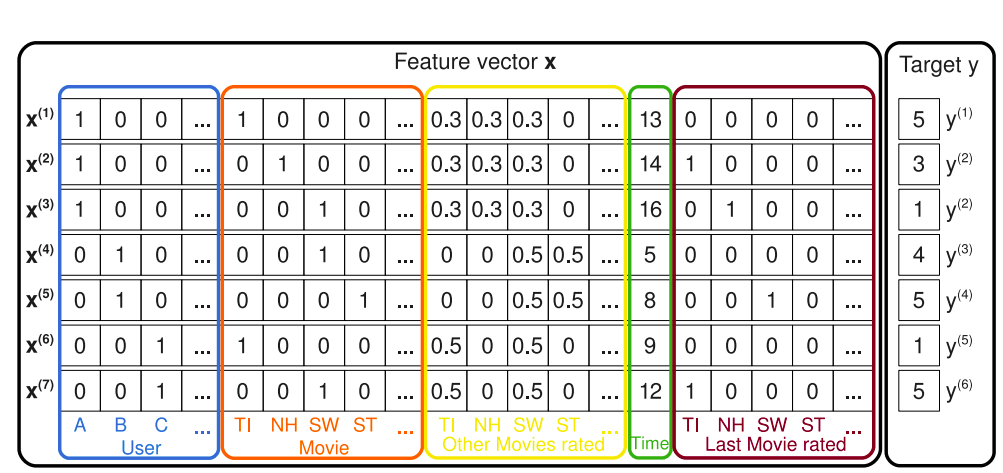

We could do a similar thing. We could add UserId to our features or take publisher as a User, since advertisers usually target a group of people with specific interest and the audience of publishers are naturally grouped by interests. </br>
Now we want our users to rate some ads. they could either rate it 1 or zero. we could also use advertiserId or campaignId instead of creativeId to reduce features dimensions. </br>
So whats new is that we could generate two new fields: **Other Ads Clicked** and **Last Ad Clicked**. </br>
We would use timestamp to detect **Last Ad Clicked**. We would also average the clicked in **Other Ads Clicked** like the above picture to normalize the ratings.

## Decision Making Method

Each data has a displayId. If we group the data by displayId we will see that in each group, one and only one of the data points are clicked. This means that the problem is not just about predicting the probability clicked base on some features, but it is about selecting the most probable one. For example, lets assume that if p(x) > 0.5 then we decide that click has happend. Now imagine we have a group of data with p=[0.6, 0.7, 0.8], so we predict that all of them will clicked but we know for a fact that exactly one of the is clicked. The simial scenario is applied for a group of p=[0.2, 0.3, 0.4], we predict all of them as not-clicked but one of them is actualy clicked. So be porpuse a decision making methon that groups test_data by displayId, predict each data individualy and choose the data with the highest probability as clicked and others as not-clicked </br>
We have implemented and applied this method to the dataset. The make_decision function is as below:

In [ ]:
def make_decision(test_data, y_pred_prob):
  result_data = test_data.copy()
  result_data["y_pred_prob"] = y_pred_prob
  mx_y_pred_prob = result_data.groupby("displayId")[["y_pred_prob"]].max().rename(columns={'y_pred_prob':'max_prob'})
  result_data = result_data.join(mx_y_pred_prob, on='displayId')
  y_pred_final = (result_data['y_pred_prob'] == result_data['max_prob']) * 1
  y_pred_final = y_pred_final.values
  return y_pred_final

# Predict clicked for the given test-set

In [226]:
_, _, _, _, X_very_test, _ = get_datasets(
    balance_train_data, validation_data, very_test_data, 
    fields,
    fields,
)
X_very_test

<1072876x3676 sparse matrix of type '<class 'numpy.float64'>'
	with 5047605 stored elements in Compressed Sparse Row format>

In [227]:
y_very_test_predict = fm.predict(X_very_test)
y_very_test_predict

array([1, 1, 0, ..., 0, 0, 0])

In [228]:
np.savetxt("result.csv", y_very_test_predict, delimiter=",")